## Conv1D, using osc, prc and macd data and their derivatives

In [1]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [4]:
def read_data_files():
    data = pd.DataFrame()
    
    for filename in os.listdir('../data/UBC/'):
        if filename.endswith(".txt"): 
            # print('working on ', filename)
            # symbol = filename.split("1")[0]
            tmp_df = pd.read_csv(os.path.join('../data/UBC/', filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            # tmp_df = pd.concat([pd.Series([symbol] * tmp_df.shape[0], name = 'symbol'), tmp_df], axis=1)
            tmp_df = tmp_df.iloc[20:,:]
            tmp_df[180] = (tmp_df[179] + tmp_df[181])/2    # column 180 data is wrong, so replace it with mean value of column 179 and 181
            data = pd.concat([data, tmp_df])
    
    osc_names = ['osc' + str(i) for i in range(118)]
    prc_names = ['prc' + str(i) for i in range(118)]
    macd_names = ['macd' + str(i) for i in range(118)]
    data.columns = osc_names + prc_names + macd_names + ['rtn']
    
    osc_data = data.iloc[:, :118].reset_index(drop=True)
    osc_data = osc_data[osc_data.columns[::-1]]
    # osc_data = normalize_data(osc_data)
    
    prc_data = data.iloc[:, 118:236].reset_index(drop=True)
    prc_data = prc_data[prc_data.columns[::-1]]
    # prc_data = normalize_data(prc_data)
    
    macd_data = data.iloc[:, 236:354].reset_index(drop=True)
    macd_data = macd_data[macd_data.columns[::-1]]
    # macd_data = normalize_data(macd_data) 
    
    rtn = data['rtn'].reset_index(drop=True)
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    
    data = pd.concat([osc_data, prc_data, macd_data, rtn, label], axis=1)
    data = data.reset_index(drop=True)
    
    return data

In [5]:
def remove_duplicates(data):
    # target_names = list(data.columns)
    # del target_names[0]
    clean_data = data.drop_duplicates()
    clean_data= clean_data.reset_index(drop=True)
    return clean_data

In [6]:
def remove_extreme_values(data): 
    data = data[(data['osc1'] > -7) & (data['osc1'] < 7)] 
    data = data.reset_index(drop=True)
    return data

In [7]:
def remove_pos_values(data):
    data = data[data['osc1'] < 0]
    data = data.reset_index(drop=True)
    return data

In [8]:
def calc_derivative(data, name):
    derivatives = []
    for i in range(data.shape[0]):
        i_derivative = list(np.gradient(pd.Series(data.iloc[i,:])))
        derivatives.append(i_derivative)
    
    names = []
    for i in range(data.shape[1]):
        names.append(name + "_d"+ str(40-i)) 
    
    return pd.DataFrame(derivatives, columns=names, index=data.index)

In [9]:
def add_derivatives(data):
    osc = data.iloc[:, :118]
    prc = data.iloc[:, 118:236]
    macd = data.iloc[:, 236:354]
    rtn = data['rtn']
    label = data['label'] 
    osc_drv = calc_derivative(osc, 'osc')
    prc_drv = calc_derivative(prc, 'prc')
    macd_drv = calc_derivative(macd, 'macd')
    data = pd.concat([osc, prc, macd, osc_drv, prc_drv, macd_drv, rtn, label], axis=1)
    return data

In [10]:
class StockData():
    def __init__(self, data):

        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        
        # balance the data set 
        if pos_data.shape[0] > neg_data.shape[0]:
            pos_data = pos_data.sample(neg_data.shape[0])
        else:
            neg_data = neg_data.sample(pos_data.shape[0])
        
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
        
        X = data.iloc[:, :-1]
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [11]:
data = read_data_files()
data = remove_duplicates(data) 
data = remove_extreme_values(data)
data = remove_pos_values(data)
print(data.shape)
# print(data.columns.values)

(49109, 356)


In [12]:
data = add_derivatives(data)
print(data.shape)
# print(data.columns.values)

(49109, 710)


In [13]:
stock_data = StockData(data)
print(stock_data.X_train.shape)
print(stock_data.X_valid.shape)
print(stock_data.X_test.shape)

(22774, 708)
(7592, 708)
(10122, 708)


In [14]:
# check what is the percentage of '1' labels in test set 
sum(stock_data.y_test)/stock_data.y_test.shape[0]

0.49713495356648885

In [15]:
X_train = np.array(stock_data.X_train).reshape(stock_data.X_train.shape[0], 6, 118)
y_train = to_categorical(stock_data.y_train)
X_valid = np.array(stock_data.X_valid).reshape(stock_data.X_valid.shape[0], 6, 118)
y_valid = to_categorical(stock_data.y_valid)
X_test = np.array(stock_data.X_test).reshape(stock_data.X_test.shape[0], 6, 118)
y_test = to_categorical(stock_data.y_test)

In [16]:
X_train = np.transpose(X_train, (0, 2, 1))
X_valid = np.transpose(X_valid, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

In [17]:
model = Sequential()
model.add(Conv1D(6, kernel_size=3, input_shape=(118,6), padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(6, kernel_size=3, padding='same', activation='sigmoid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_valid, y_valid))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 22774 samples, validate on 7592 samples
Epoch 1/20
22774/22774 [==============================] - 4s 190us/step - loss: 0.6943 - acc: 0.5085 - val_loss: 0.6923 - val_acc: 0.5151
Epoch 2/20
22774/22774 [==============================] - 4s 164us/step - loss: 0.6920 - acc: 0.5139 - val_loss: 0.6925 - val_acc: 0.5109
Epoch 3/20
22774/22774 [==============================] - 3s 147us/step - loss: 0.6925 - acc: 0.5035 - val_loss: 0.6921 - val_acc: 0.5130
Epoch 4/20
22774/22774 [==============================] - 4s 162us/step - loss: 0.6917 - acc: 0.5141 - val_loss: 0.6921 - val_acc: 0.5133
Epoch 5/20
22774/22774 [==============================] - 4s 177us/step - loss: 0.6917 - acc: 0.5125 - val_loss: 0.6934 - val_acc: 0.4950
Epoch 6/20
22774/22774 [==============================] - 3s 153us/step - loss: 0.6918 - acc: 0.5075 - val_loss: 0.6922 - val_acc: 0.5163
Epo

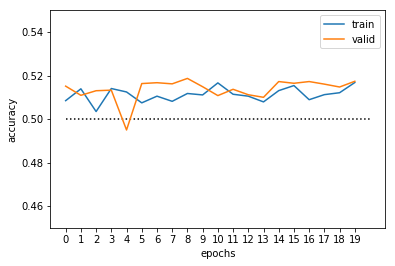

In [18]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 20, linestyles='dotted')
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [19]:
scores = model.evaluate(X_valid, y_valid, verbose=1)
scores

7592/7592 [==============================] - 1s 70us/step


[0.6919976444591084, 0.5173867228661749]

In [20]:
pred = model.predict(X_valid)
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, stock_data.y_valid.reset_index(drop = True), stock_data.valid_rtn.reset_index(drop = True)], 
                    axis = 1)
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
pred_prob_level,,,,,
0.20,0.228202,0.277778,0.263889,18,0.237092
0.25,0.277510,0.272727,-0.927727,22,0.289779
0.30,0.322479,0.341463,0.324634,41,0.540042
0.35,0.379368,0.448276,0.742069,29,0.381981
0.40,0.430054,0.426230,0.010492,61,0.803477
0.45,0.488848,0.471823,0.261923,905,11.920443
0.50,0.514834,0.513045,0.294236,6516,85.827187


In [21]:
model = Sequential()
model.add(Conv1D(6, kernel_size=3, input_shape=(118,6), padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(6, kernel_size=3, padding='same', activation='sigmoid'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 22774 samples, validate on 10122 samples
Epoch 1/20
22774/22774 [==============================] - 5s 228us/step - loss: 0.6935 - acc: 0.5108 - val_loss: 0.6923 - val_acc: 0.5052
Epoch 2/20
22774/22774 [==============================] - 4s 180us/step - loss: 0.6920 - acc: 0.5090 - val_loss: 0.6921 - val_acc: 0.5029
Epoch 3/20
22774/22774 [==============================] - 4s 178us/step - loss: 0.6917 - acc: 0.5100 - val_loss: 0.6922 - val_acc: 0.5062
Epoch 4/20
22774/22774 [==============================] - 4s 188us/step - loss: 0.6916 - acc: 0.5098 - val_loss: 0.6918 - val_acc: 0.5029
Epoch 5/20
22774/22774 [==============================] - 4s 180us/step - loss: 0.6917 - acc: 0.5059 - val_loss: 0.6917 - val_acc: 0.5030
Epoch 6/20
22774/22774 [==============================] - 4s 178us/step - loss: 0.6916 - acc: 0.5086 - val_loss: 0.6920 - val_acc: 0.5069
Epoch 7/20
22774/22774 [==============================] - 4s 181us/step - loss: 0.6914 - acc: 0.5117 - val_loss: 0.6934 - 

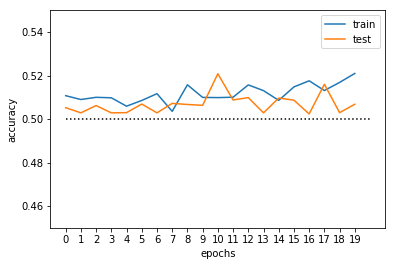

In [22]:
# results using training set and test set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 20, linestyles='dotted')
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test']);

In [23]:
scores = model.evaluate(X_test, y_test, verbose=1)
scores

10122/10122 [==============================] - 1s 55us/step


[0.6949518876239684, 0.5068168346294417]

In [24]:
pred = model.predict(X_test)
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, stock_data.y_test.reset_index(drop = True), stock_data.test_rtn.reset_index(drop = True)], 
                    axis = 1)
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
pred_prob_level,,,,,
0.05,0.082377,0.400000,0.230667,15,0.148192
0.10,0.126135,0.384615,0.793077,13,0.128433
0.15,0.176788,0.368421,-0.200000,38,0.375420
0.20,0.226347,0.354167,-0.623958,48,0.474215
0.25,0.271582,0.125000,-0.738750,32,0.316143
0.30,0.327309,0.321429,1.012857,28,0.276625
0.35,0.378010,0.350000,0.272250,40,0.395179
0.40,0.422639,0.396226,0.336038,53,0.523612
0.45,0.484044,0.472081,0.801878,197,1.946256
